<a href="https://colab.research.google.com/github/emilianodesu/RLA2/blob/main/pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning

This notebook will explore the implementation of a Temporal-Difference (TD) method, Q-Learning, on the Pendulum environment.

## 1. Imports and Utilities

In [1]:
!pip install gymnasium pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!pip install moviepy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
import sys
import os
import gymnasium as gym
import numpy as np
import random
import glob
import io
import base64
from collections import namedtuple, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo
from pyvirtualdisplay import Display

# Start the virtual display
try:
    display.stop()
except:
    pass
display = Display(visible=0, size=(1400, 900))
display.start()

# Helper plotting functions from your example
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

### Utilities

#### Plot Values

In [3]:
def plot_episode_stats(stats, smoothing_window=10, no_show=False):
    """Function to plot the Episode statistics
    Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py"""
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10, 5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if no_show:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10, 5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title(f"Episode Reward over Time (Smoothed over window size {smoothing_window})")
    if no_show:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

#### Discretizer Wrapper for the Environment

In [4]:
class Discretizer(gym.ObservationWrapper):
    def __init__(self, env, bins):
        super().__init__(env)
        self.bins = bins
        self.n_bins = len(bins)

        # Create a new discrete observation space
        self.observation_space = gym.spaces.MultiDiscrete(self.bins)

    def observation(self, obs):
        # Discretize the continuous observation
        discretized_obs = []
        for i in range(len(obs)):
            # Get the high and low bounds for the current observation dimension
            low = self.env.observation_space.low[i]
            high = self.env.observation_space.high[i]

            # Calculate the bin index
            bin_index = int(((obs[i] - low) / (high - low)) * (self.bins[i] - 1))

            # Ensure the index is within bounds
            bin_index = max(0, min(self.bins[i] - 1, bin_index))
            discretized_obs.append(bin_index)

        return tuple(discretized_obs)

## 2. Q-Learning

In [5]:
def q_learning_pendulum(env, num_episodes, action_bins, gamma=0.99, alpha=0.1, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.0001):
    """
    Q-Learning algorithm adapted for a discretized continuous environment.
    Uses a defaultdict for the Q-table to handle tuple-based states.
    """
    epsilon = epsilon_start
    # Use defaultdict to handle the tuple state representation from our discretizer
    Q = defaultdict(lambda: np.zeros(len(action_bins))) # <-- Use len(action_bins)

    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Action discretization is now done outside and passed in
    # REMOVED THIS LINE: action_bins = np.linspace(env.action_space.low[0], env.action_space.high[0], num_action_bins)

    for episode in range(num_episodes):
        if (episode + 1) % 100 == 0:
            print(f"\rEpisode {episode + 1}/{num_episodes}", end="")
            sys.stdout.flush()

        state, _ = env.reset()
        done = False

        while not done:
            # Epsilon-greedy action selection from our discrete action bins
            if random.uniform(0, 1) < epsilon:
                action_index = env.action_space.sample()
            else:
                action_index = np.argmax(Q[state])

            # Convert discrete action index back to continuous value for the real env
            continuous_action = [action_bins[action_index]]

            next_state, reward, terminated, truncated, info = env.step(continuous_action)
            done = terminated or truncated

            # Update stats
            stats.episode_rewards[episode] += reward
            stats.episode_lengths[episode] += 1

            # Q-learning update rule
            best_next_action_q = np.max(Q[next_state])
            td_target = reward + gamma * best_next_action_q
            td_error = td_target - Q[state][action_index]
            Q[state][action_index] += alpha * td_error

            state = next_state

        if epsilon > epsilon_end:
            epsilon -= epsilon_decay

    return Q, stats

## 3. Running Q-Learning on Pendulum Environment

In [6]:
# --- 1. Setup the Environment ---
continuous_env = gym.make('Pendulum-v1')
BINS = [30, 30, 30]
env = Discretizer(continuous_env, BINS)

# --- 2. Define Parameters ---
NUM_ACTION_BINS = 15
env.action_space = gym.spaces.Discrete(NUM_ACTION_BINS)

NUM_EPISODES = 300000
ALPHA = 0.1
GAMMA = 0.99

# Epsilon Decay Parameters
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / (NUM_EPISODES * 0.8) # Decay over 80% of episodes

# --- 3. Train the Agent ---
print("Training the agent...")

# Create the mapping from discrete action index to continuous torque value
# Do this using the ORIGINAL environment's action space bounds
action_bins = np.linspace(
    continuous_env.action_space.low[0],
    continuous_env.action_space.high[0],
    NUM_ACTION_BINS
)

# Pass the pre-computed action_bins into the function
Q_table, stats = q_learning_pendulum(env, NUM_EPISODES, action_bins, gamma=GAMMA, alpha=ALPHA, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY)

print("\nTraining finished.")

Training the agent...
Episode 300000/300000
Training finished.


#### Evaluating Performance

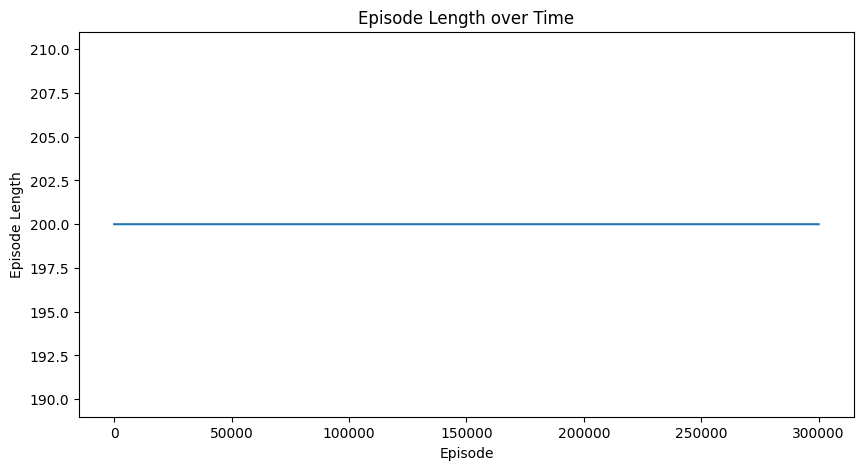

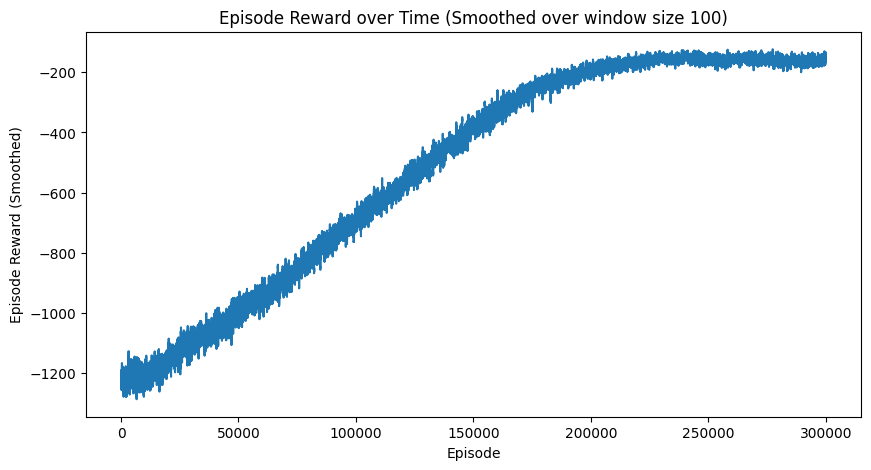

(<Figure size 1000x500 with 1 Axes>, <Figure size 1000x500 with 1 Axes>)

In [7]:
# Evaluate the agent's performance by plotting the rewards
plot_episode_stats(stats, smoothing_window=100)

In [8]:
stats.episode_rewards.mean()

np.float64(-518.7231732753174)

#### Simulate and show video

In [9]:
def simulate_pendulum_with_policy(env_id, policy, bins, action_bins):
    """
    Simulates the Pendulum environment using a learned policy from a discretized Q-table.
    """
    video_folder = f"./{env_id}_videos_policy"

    # Create the original continuous environment for rendering
    continuous_env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(continuous_env, video_folder=video_folder)

    # We need the discretizer logic here to convert continuous states to policy keys
    discretizer = Discretizer(continuous_env, bins)

    (continuous_state, info) = env.reset()
    done = False

    while not done:
        # Discretize the current continuous state to find the action in our policy
        discrete_state = discretizer.observation(continuous_state)

        # Get the best action index from the policy
        # If the state was never seen during training, default to a random action (e.g., 0)
        action_index = policy.get(discrete_state, 0)

        # Convert action index to continuous action value
        continuous_action = [action_bins[action_index]]

        continuous_state, reward, terminated, truncated, info = env.step(continuous_action)
        done = terminated or truncated

    env.close()

    # Display video logic from your original code
    mp4list = glob.glob(f'{video_folder}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        return HTML(data=f'''<video alt="test" autoplay loop controls style="height: 400px;">
                                <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                             </video>''')
    return "No videos found."

# Extract the best policy from the Q-table
policy = {state: np.argmax(actions) for state, actions in Q_table.items()}

# Define the action bins again for the simulation function
action_bins_for_sim = np.linspace(continuous_env.action_space.low[0], continuous_env.action_space.high[0], NUM_ACTION_BINS)


# Simulate and show the video
simulate_pendulum_with_policy('Pendulum-v1', policy, BINS, action_bins_for_sim)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
